# Lab One: Visualization and Data Preprocessing

by Nino Castellano, Aayush Dalal, Chloe Prowse, Muskaan Mahes

## 1. Business Understanding 

The Student Placement Dataset from Kaggle was collected and analyzed to determine whether students’ results were sufficient to obtain a job offer. The dataset contained over 50,000 records consisting of academic, technical, and soft-skill attributes that can influence the outcome of being placed or not. Therefore, the primary purpose of the dataset is to help students and educational institutions understand which factors are crucial for achieving a successful placement outcome. Using placement results is important, as they can provide real-world examples that can serve as a template for assessing how well a student is prepared for the job market. 

The main objective of this analysis is to explore the relationships between students’ key features and their placement outcome to identify important insights. Therefore, the target variable from the training set, placement status, was used to measure the effectiveness of the student outcome. 


## 2. Data Understanding

### 2.1 Describing the Meaning and Type of Data for Each Feature

### 2.2 Verifying Data Quality (Missing Values, Duplicate Data, Outliers)

After analyzing the dataset, no missing or duplicated data was identified. However, after calculating the interquartile range (IQR) for each numeric variable, several columns were flagged to have potential outliers. These variables were identified to be CGPA, Internships, Projects, and Soft_Skills_Rating. 

### 2.3 Give Simple Appropriate Statistics 

### 2.4 Visualize Most Important Features

While the previous section examined each variable individually using descriptive statistics and intuition to assess potential relevance to job placement, this analysis moves toward a model-based approach. To quantitatively evaluate which features contribute most to predicting placement outcomes, we next apply a Random Forest classifier and examine its feature importance scores.

#### Approach:
1. Run Random Forest Feature Selection Algorithm to access Feature Importance (No Feature Scaling Required)
2. Visualize Important Features

#### Why Use a Random Forest for Feature Importance?
A Random Forest is an ensemble learning method that builds multiple decision trees using different subsets of the data and features. Because each tree makes decisions by repeatedly splitting the data to reduce classification error, the model naturally provides a way to measure how useful each feature is for making accurate predictions.

Feature importance in a Random Forest is computed by measuring how much each feature reduces impurity across all decision trees in the forest. At each split in a tree, the algorithm selects the feature that best separates the data by reducing impurity (measured using metrics such as Gini impurity). The total reduction in impurity contributed by a feature is accumulated across all trees and then normalized so that the importance scores sum to one.

In other words, features that are repeatedly chosen to make informative splits—and lead to purer groupings of placed versus not placed students—receive higher importance scores.

Using this framework, we trained a Random Forest classifier on all available features and extracted the resulting importance scores. The following figure visualizes the relative importance of each variable in predicting job placement.


Top 15 Features (All Variables Model):
 1) Communication_Skills                     0.3147
 2) Backlogs                                 0.1787
 3) CGPA                                     0.1619
 4) Coding_Skills                            0.0979
 5) Projects                                 0.0930
 6) Certifications                           0.0731
 7) Aptitude_Test_Score                      0.0639
 8) Internships                              0.0086
 9) Age                                      0.0018
10) Soft_Skills_Rating                       0.0017
11) Branch_Civil                             0.0011
12) Gender_Male                              0.0006
13) Branch_IT                                0.0006
14) Branch_ME                                0.0005
15) Degree_BCA                               0.0004


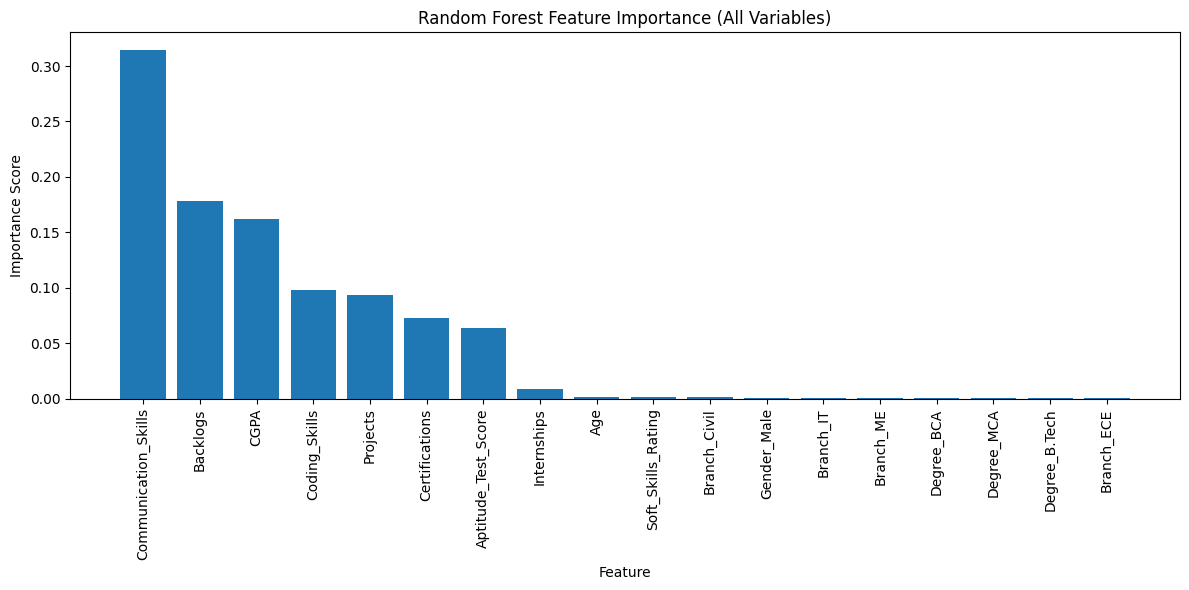

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import pandas as pd

# Importing Train Dataset for Intial EDA
df = pd.read_csv("../Student Placement Dataset/train.csv")

# Importing Train Dataset for Model Training
train_df = pd.read_csv("../Student Placement Dataset/train.csv")

# Impoting Test Dataset for Final Predictions
test_df = pd.read_csv("../Student Placement Dataset/test.csv")

# All Feature Except Target
numeric_features = [
    'Age',
    'CGPA',
    'Internships',
    'Projects',
    'Coding_Skills',
    'Communication_Skills',
    'Aptitude_Test_Score',
    'Soft_Skills_Rating',
    'Certifications',
    'Backlogs'
]

categorical_features = [
    'Branch',
    'Degree',
    'Gender'
]

# Create X and Y
X_train = train_df[numeric_features + categorical_features]
y_train = train_df['Placement_Status']

X_test = test_df[numeric_features + categorical_features]
y_test = test_df['Placement_Status']

# One-Hot Encode Nominal Features
X_train_encoded = pd.get_dummies(
    X_train,
    columns=categorical_features,
    drop_first=True
)

X_test_encoded = pd.get_dummies(
    X_test,
    columns=categorical_features,
    drop_first=True
)

# Align Train & Test Columns (CRITICAL)
X_train_encoded, X_test_encoded = X_train_encoded.align(
    X_test_encoded,
    join='left',
    axis=1,
    fill_value=0
)

# Train Random Forest (Same Hyperparameters)
rf_all = RandomForestClassifier(
    n_estimators=500,
    random_state=42,
    n_jobs=-1
)

rf_all.fit(X_train_encoded, y_train)

# Feature Importance (All Variables)
importances = rf_all.feature_importances_
feature_names = X_train_encoded.columns
indices = np.argsort(importances)[::-1]

# Print Feature Rankings
print("\nTop 15 Features (All Variables Model):")
for i in range(15):
    print(
        f"{i+1:2d}) {feature_names[indices[i]]:<40} {importances[indices[i]]:.4f}"
    )

# Feature Importance Plot
plt.figure(figsize=(12,6))
plt.title('Random Forest Feature Importance (All Variables)')

plt.bar(
    range(len(feature_names)),
    importances[indices],
    align='center'
)

plt.xticks(
    range(len(feature_names)),
    feature_names[indices],
    rotation=90
)

plt.ylabel('Importance Score')
plt.xlabel('Feature')
plt.tight_layout()
plt.show()


The feature importance plot ranks variables based on their relative contribution to the model’s predictive performance. Higher bars indicate features that more frequently and more effectively reduce classification uncertainty across the ensemble of trees. While these scores do not imply causation, they provide a strong indication of which variables contain the most predictive signal.

Because categorical variables were one-hot encoded, individual category levels appear separately, and their importance should be interpreted collectively rather than in isolation.

Based on these results, we next focus our analysis on the most influential features identified by the Random Forest in order of their importance:

- Communication_Skills
- Backlogs
- CGPA
- Coding_Skills
- Projects
- Certifications
- Aptitude_Test_Score
- Internships

These variables are further explored through targeted visualizations to better understand how they relate to placement outcomes.

Because categorical variables were one-hot encoded (Branch and Degree), individual category levels appear separately, and their importance should be interpreted collectively rather than in isolation. We will also look at Soft Skills since it was the least important but still to look at it closley. 

#### Communication Feature

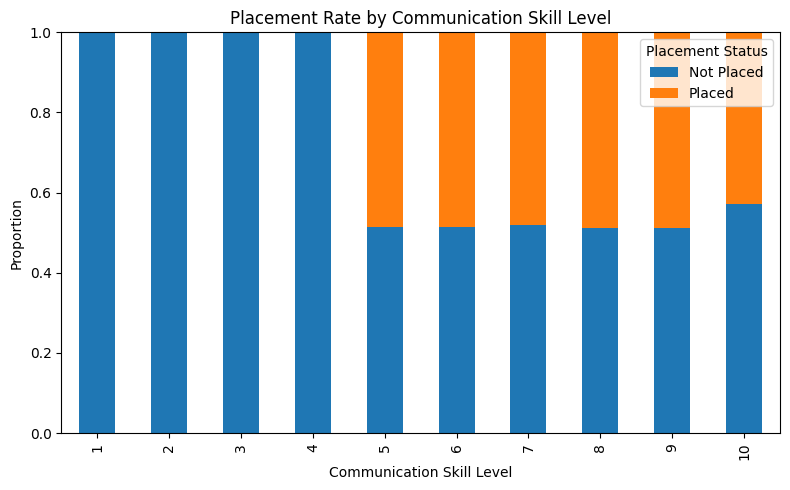

In [40]:
# Ensure correct order
comm_levels = sorted(df['Communication_Skills'].dropna().unique())

comm_counts = (
    df.groupby(['Communication_Skills', 'Placement_Status'])
    .size()
    .unstack(fill_value=0)
)

comm_counts = comm_counts.reindex(comm_levels, fill_value=0)

comm_norm = comm_counts.div(
    comm_counts.sum(axis=1),
    axis=0
)

comm_norm.plot(
    kind='bar',
    stacked=True,
    figsize=(8, 5)
)

plt.title('Placement Rate by Communication Skill Level')
plt.xlabel('Communication Skill Level')
plt.ylabel('Proportion')
plt.legend(title='Placement Status')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

To analyze the impact of communication skills on placement outcomes, a stacked bar chart was chosen to visualize the proportion of students placed versus not placed across different communication skill levels. The results reveal a clear pattern: individuals with communication skill levels from 1 to 4 were entirely not placed, indicating that low communication proficiency may be a critical barrier to employability. The plot reveals an interesting nuance: from communication skill levels 5 through 8, the placement rate appears relatively flat.  There’s no dramatic jump in the proportion of placed students across these mid‑range levels, which suggests that within this band, communication skill alone may not be a strong differentiator for placement outcomes.

#### Backlog Feature

In [ ]:
plt.figure(figsize=(8,5))
sns.countplot(
    data=df,
    x='Backlogs',
    hue='Placement_Status'
)

plt.title('Placement Status by Number of Backlogs')
plt.xlabel('Number of Backlogs')
plt.ylabel('Student Count')
plt.show()

To assess the impact of academic backlogs on placement outcomes, a bar chart was used to compare student counts across different backlog levels and placement statuses. The results show a strong inverse relationship: students with zero backlogs have the highest placement count, while those with one backlog already show a sharp drop in placement numbers. For students with two or more backlogs, placement is nonexistent—every student in these categories is not placed. This stark pattern suggests that even a single backlog significantly reduces placement chances, and multiple backlogs may act as a hard barrier to employability. The visual underscores the importance of academic consistency and reinforces backlog count as a critical feature in predicting placement success.

In [ ]:
backlog_rate = (
    df.groupby(['Backlogs', 'Placement_Status'])
    .size()
    .unstack(fill_value=0)
)

backlog_norm = backlog_rate.div(backlog_rate.sum(axis=1), axis=0)

backlog_norm.plot(
    kind='bar',
    stacked=True,
    figsize=(8,5)
)

plt.title('Placement Rate by Number of Backlogs')
plt.xlabel('Number of Backlogs')
plt.ylabel('Proportion of Students')
plt.legend(title='Placement Status')
plt.show()

This proportion-based bar chart reinforces the strong negative impact of academic backlogs on placement probability. Students with zero backlogs show a substantial placement rate, while those with one backlog experience a noticeable drop. For students with two or three backlogs, the placement rate falls to zero—every individual in these categories is not placed. This visual confirms the earlier observation: as the number of backlogs increases, placement probability sharply declines, with multiple backlogs acting as a clear barrier to employability. The pattern is consistent and decisive, making backlog count a critical feature for predicting placement outcomes.

#### C-GPA Feature

In [ ]:
plt.figure(figsize=(8,5))
sns.boxplot(x='Placement_Status', y='CGPA', data=df)

plt.title('CGPA Distribution by Placement Status')
plt.xlabel('Placement Status')
plt.ylabel('CGPA')
plt.show()

To examine how CGPA relates to placement outcomes, I chose a box plot to visualize the distribution of GPAs for placed and not placed students. Box plots are ideal for comparing central tendency, spread, and outliers between groups, making it easier to detect meaningful differences.

The results show a noticeable shift in CGPA distributions between the two groups. Students who were placed tend to have higher GPAs, with a median around 7.5, compared to about 6.5 for those not placed. The placed group also shows a tighter interquartile range and fewer low-end values. This suggests that higher academic performance may be positively associated with placement success, making CGPA a potentially important predictor.

In [ ]:
plt.figure(figsize=(8,5))

sns.histplot(
    data=df,
    x='CGPA',
    hue='Placement_Status',
    bins=15,
    kde=True,
    element='step'
)

plt.title('CGPA Distribution by Placement Status')
plt.xlabel('CGPA')
plt.ylabel('Count')
plt.show()

To gain deeper insight into how CGPA relates to placement outcomes, I used a distribution chart with overlaid density plots. This visualization allows us to compare the full shape of CGPA distributions for placed and not placed students, beyond just summary statistics.

The results show a clear separation between the two groups. Students who were placed tend to have higher CGPAs, with their distribution skewed toward the upper end of the scale. In contrast, the not placed group is more concentrated around lower CGPA values. This pattern reinforces the earlier box plot findings and suggests that higher academic performance is associated with a greater likelihood of placement.

In [ ]:
import numpy as np

# Bin CGPA
df['CGPA_bin'] = pd.cut(df['CGPA'], bins=8)

placement_prob = (
    df[df['Placement_Status'] == 'Placed']
    .groupby('CGPA_bin')
    .size() / df.groupby('CGPA_bin').size()
)

plt.figure(figsize=(8,5))
plt.plot(
    placement_prob.index.astype(str),
    placement_prob.values,
    marker='o'
)

plt.title('Placement Probability by CGPA Range')
plt.xlabel('CGPA Range')
plt.ylabel('Placement Probability')
plt.xticks(rotation=45)
plt.ylim(0,1)
plt.show()

To explore how CGPA influences placement outcomes more precisely, I plotted placement probability across CGPA ranges. This approach goes beyond summary statistics and shows how the likelihood of being placed changes as academic performance improves.

The results reveal a clear upward trend. Students with CGPAs below 6.5 have near-zero placement probability, but the likelihood increases steadily with higher CGPA ranges. In the top range (above 9.1), placement probability reaches around 75%. This pattern strongly suggests that higher CGPA is positively associated with placement success, reinforcing earlier findings from the box plot and distribution chart.

#### Coding Skills Feature

In [ ]:
coding_counts = (
    df.groupby(['Coding_Skills', 'Placement_Status'])
    .size()
    .unstack(fill_value=0)
)

# Ensure ordinal order (1 → highest, or as defined in your data)
coding_counts = coding_counts.sort_index()

# Plot stacked bar chart
coding_counts.plot(
    kind='bar',
    stacked=True,
    figsize=(8,5)
)

plt.title('Placement Status by Coding Skill Level (Counts)')
plt.xlabel('Coding Skill Level')
plt.ylabel('Number of Students')
plt.legend(title='Placement Status')
plt.show()

To evaluate how coding skill level influences placement outcomes, I used a bar chart showing placement counts across skill levels from 1 to 10. This visualization helps identify trends in employability as coding proficiency increases.

The results show a clear upward pattern. Students with lower coding skill levels (especially 1–4) are predominantly not placed, while those with higher skill levels (5–10) show a growing proportion of placements. The shift becomes especially noticeable around level 5, where the number of placed students begins to rival or exceed the not placed group. This suggests that stronger coding skills are positively associated with placement success, likely reflecting the technical requirements of the roles students are entering.

In [ ]:
# Ensure correct ordering
skill_levels = sorted(df['Coding_Skills'].dropna().unique())

coding_counts = (
    df.groupby(['Coding_Skills', 'Placement_Status'])
    .size()
    .unstack(fill_value=0)
)

coding_counts = coding_counts.reindex(skill_levels, fill_value=0)

coding_norm = coding_counts.div(
    coding_counts.sum(axis=1),
    axis=0
)

coding_norm.plot(
    kind='bar',
    stacked=True,
    figsize=(8,5)
)

plt.title('Placement Rate by Coding Skill Level')
plt.xlabel('Coding Skill Level')
plt.ylabel('Proportion')
plt.legend(title='Placement Status')
plt.ylim(0, 1)
plt.show()

To assess how coding proficiency affects placement outcomes, I used a normalized bar chart showing placement proportions across coding skill levels from 1 to 10. This approach removes bias from group size differences and focuses purely on the likelihood of placement at each skill level.

The results reveal a striking pattern. Students with coding skill levels between 1 and 4 have a 100% not placed rate — none of them secured placements. Starting from level 5, placement probability begins to rise, and by levels 9 and 10, the majority of students are placed. This suggests a strong threshold effect: low coding skill is a major barrier to placement, while higher proficiency significantly improves employability.

In [ ]:
plt.figure(figsize=(7,4))
plt.plot(
    placement_rate.index,
    placement_rate.values,
    marker='o'
)

plt.title('Probability of Placement vs Coding Skill Level')
plt.xlabel('Coding Skill Level')
plt.ylabel('Placement Probability')
plt.ylim(0,1)
plt.show()

To reinforce the upward trend observed in earlier visualizations, I plotted placement probability against coding skill level. This line graph offers a clean, continuous view of how placement likelihood evolves as coding proficiency increases.

The results confirm a strong positive relationship. Placement probability rises steadily from level 5 onward, reaching its peak near level 10. This consistent increase supports the conclusion that higher coding skill levels are strongly associated with better placement outcomes, making this feature a compelling candidate for inclusion in predictive modeling.

#### Projects Feature

In [ ]:
plt.figure(figsize=(8,5))
sns.countplot(
    data=df,
    x='Projects',
    hue='Placement_Status'
)

plt.title('Placement Status by Number of Projects')
plt.xlabel('Number of Projects')
plt.ylabel('Student Count')
plt.show()

To examine how project experience relates to placement outcomes, I used a bar chart showing the count of placed and not placed students across different project counts. This visualization helps reveal how placement status varies with the number of completed projects, making it easier to spot trends in employability.

The results suggest a positive relationship. Students with fewer projects (1–3) are more likely to be not placed, while those with 4 or more projects show higher placement counts. The shift becomes especially noticeable at 4 projects, where the number of placed students overtakes the not placed group. This pattern indicates that project experience may contribute meaningfully to placement success, possibly by signaling stronger skills or initiative.

In [ ]:
project_rate = (
    df.groupby(['Projects', 'Placement_Status'])
    .size()
    .unstack()
)

project_norm = project_rate.div(
    project_rate.sum(axis=1),
    axis=0
)

project_norm.plot(
    kind='bar',
    stacked=True,
    figsize=(8,5)
)

plt.title('Placement Rate by Number of Projects')
plt.xlabel('Number of Projects')
plt.ylabel('Proportion')
plt.legend(title='Placement Status')
plt.show()

To eliminate bias from raw counts, I used a proportion-based bar chart to analyze placement outcomes across project counts. This visualization reveals not just how many students were placed, but how likely placement was within each project group.

The results show a sharp divide at lower project counts. For students with 1 or 2 projects, placement rates are effectively zero — the bars are entirely blue, indicating that none of these students were placed. Placement probability begins to rise only from 3 projects onward, suggesting a possible threshold effect. This pattern implies that having very few projects may significantly reduce placement chances, and that a minimum level of project experience could be critical for employability.

In [ ]:
placement_prob = (
    df[df['Placement_Status'] == 'Placed']
    .groupby('Projects')
    .size() / df.groupby('Projects').size()
)

plt.figure(figsize=(7,4))
plt.plot(
    placement_prob.index,
    placement_prob.values,
    marker='o'
)

plt.title('Probability of Placement vs Number of Projects')
plt.xlabel('Number of Projects')
plt.ylabel('Placement Probability')
plt.ylim(0,1)
plt.show()

To reinforce the pattern observed in earlier visualizations, I plotted placement probability against the number of projects. This line graph offers a clearer view of how placement likelihood changes as project experience increases.

The results show a strong upward trend. Placement probability rises sharply from just 10% at 3 projects to 80% at 6 projects, suggesting a consistent and meaningful relationship. This supports the idea that students with more project experience are significantly more likely to be placed, highlighting project count as a potentially influential predictor of placement success.

#### Certification Feature 

In [ ]:
plt.figure(figsize=(8,5))
sns.countplot(
    data=df,
    x='Certifications',
    hue='Placement_Status'
)

plt.title('Placement Status by Number of Certifications')
plt.xlabel('Number of Certifications')
plt.ylabel('Student Count')
plt.show()

To explore the impact of certifications on placement outcomes, a bar chart was used to compare student counts across different certification levels and placement statuses. The visual shows that students with zero or one certification are predominantly not placed, while those with two certifications have a more balanced distribution. Notably, students with three certifications show a higher number of placements than non-placements, suggesting that having multiple certifications may positively influence placement success. This trend implies that certifications could serve as a valuable differentiator in the job selection process, especially when accumulated beyond a basic level.

In [ ]:
cert_rate = (
    df.groupby(['Certifications', 'Placement_Status'])
    .size()
    .unstack(fill_value=0)
)

cert_norm = cert_rate.div(cert_rate.sum(axis=1), axis=0)

cert_norm.plot(
    kind='bar',
    stacked=True,
    figsize=(8,5)
)

plt.title('Placement Rate by Number of Certifications')
plt.xlabel('Number of Certifications')
plt.ylabel('Proportion of Students')
plt.legend(title='Placement Status')
plt.show()

To better understand how the number of certifications influences placement outcomes, a proportion-based bar chart was used to visualize placement rates across certification levels. This chart removes the bias of raw counts and focuses on relative success within each group. The results show a clear upward trend: students with zero certifications were entirely not placed, and those with one certification had very low placement rates. At two certifications, placement and non-placement proportions are nearly equal, while students with three certifications show a noticeably higher placement rate. This pattern suggests that accumulating more certifications may significantly improve placement probability, especially beyond the one-certification threshold, reinforcing the value of continuous skill development in enhancing employability.

#### Aptitude Test Score Feature

In [ ]:
plt.figure(figsize=(8,5))
sns.boxplot(x='Placement_Status', y='Aptitude_Test_Score', data=df)

plt.title('Aptitude Test Score Distribution by Placement Status')
plt.xlabel('Placement Status')
plt.ylabel('Aptitude Test Score')
plt.show()

To examine how aptitude test scores relate to placement outcomes, a box plot was used to compare score distributions between placed and not placed students. This visualization highlights key differences: placed students tend to have higher median scores and a tighter interquartile range, while not placed students show a wider spread and lower central tendency. The contrast in distributions suggests that stronger aptitude performance may be associated with a greater likelihood of placement, making test scores a potentially influential factor in the selection process.

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(
    data=df,
    x='Aptitude_Test_Score',
    hue='Placement_Status',
    bins=15,
    kde=True,
    element='step'
)

plt.title('Aptitude Test Score Distribution by Placement Status')
plt.xlabel('Aptitude Test Score')
plt.ylabel('Count')
plt.show()

To further explore how aptitude test scores relate to placement outcomes, a histogram with overlaid density plots was used to compare score distributions between placed and not placed students. This visualization reinforces the differences observed in the earlier box plot: the distribution for placed students is clearly shifted toward higher scores, with a peak around the 75–85 range. In contrast, the not placed group shows a broader spread with a peak closer to the 60–65 range and a longer tail toward lower scores. The separation between the two density curves suggests that higher aptitude scores are more common among placed individuals, supporting the idea that test performance may play a meaningful role in placement decisions. This visual not only confirms the central tendency differences but also highlights how the overall shape and concentration of scores differ between the two groups.

In [ ]:
# Bin scores into 10-point ranges
df['Score_bin'] = pd.cut(df['Aptitude_Test_Score'], bins=10)

placement_prob = (
    df[df['Placement_Status'] == 'Placed']
    .groupby('Score_bin')
    .size() / df.groupby('Score_bin').size()
)

plt.figure(figsize=(8,5))
plt.plot(
    placement_prob.index.astype(str),
    placement_prob.values,
    marker='o'
)

plt.title('Placement Probability by Aptitude Test Score Range')
plt.xlabel('Aptitude Test Score Range')
plt.ylabel('Placement Probability')
plt.ylim(0,1)
plt.xticks(rotation=45)
plt.show()

To assess how aptitude test scores influence placement likelihood, a line graph was used to plot placement probability across score ranges. This visualization provides a clear, continuous view of how placement outcomes shift with increasing test performance. The results show a steady upward trend: placement probability begins near zero in the lowest score range and rises consistently across intervals, reaching approximately 70% in the highest range. This pattern reinforces the idea that higher aptitude scores are strongly associated with greater placement success, making test performance a valuable predictor in modeling and decision-making. The smooth progression also suggests that improvements in test scores—even within moderate ranges—can meaningfully enhance placement chances.

#### Internship Feature

In [ ]:
plt.figure(figsize=(8,5))
sns.countplot(
    data=df,
    x='Internships',
    hue='Placement_Status'
)

plt.title('Placement Status by Number of Internships')
plt.xlabel('Number of Internships')
plt.ylabel('Student Count')
plt.show()

To explore how internship experience affects placement outcomes, I used a bar chart to compare placement status across different internship counts. This visualization shows, for each internship level (0 to 3), how many students were placed versus not placed, allowing us to assess trends in placement success relative to internship exposure.

The results reveal a strong positive association. Students with no internships have the lowest placement count, while those with more internships—especially 2 or 3—show a higher proportion of placements. This suggests that internship experience may significantly boost placement chances, likely due to enhanced skills, industry exposure, and employability.

In [ ]:
internship_rate = (
    df.groupby(['Internships', 'Placement_Status'])
    .size()
    .unstack()
)

internship_norm = internship_rate.div(
    internship_rate.sum(axis=1),
    axis=0
)

internship_norm.plot(
    kind='bar',
    stacked=True,
    figsize=(8,5)
)

plt.title('Placement Rate by Internship Count')
plt.xlabel('Number of Internships')
plt.ylabel('Proportion')
plt.legend(title='Placement Status')
plt.show()

To avoid the bias introduced by raw counts, I used a proportion-based bar chart to analyze placement outcomes across internship counts. This approach normalizes the data, allowing us to compare placement rates fairly across groups of different sizes.

The results show a strong upward trend in placement proportion as internship experience increases. Students with zero internships have the lowest placement rate, while those with three internships show the highest. This pattern suggests that internship experience is positively correlated with placement success, and may be a key factor influencing employability.

#### Branch Feature

In [ ]:
branch_placement = (
    df.groupby(['Branch', 'Placement_Status'])
    .size()
    .unstack()
)

branch_norm = branch_placement.div(branch_placement.sum(axis=1), axis=0)

branch_norm.plot(
    kind='bar',
    stacked=True,
    figsize=(12,6)
)

plt.title('Placement Rate by Engineering Branch')
plt.xlabel('Engineering Branch')
plt.ylabel('Proportion')
plt.legend(title='Placement Status')
plt.xticks(rotation=45, ha='right')
plt.show()

The normalized bar chart compares placement proportions across engineering branches, revealing slight differences in placement rates. Branches like CSE and IT show marginally higher placement proportions, which could suggest that specialization may play a role in placement outcomes. However, these differences are not pronounced, and further statistical analysis would be needed to confirm whether branch is a significant predictor of placement.

In [ ]:
heatmap_data = (
    df.groupby(['Branch', 'Placement_Status'])
    .size()
    .groupby(level=0)
    .apply(lambda x: x / x.sum())
    .unstack()
)

plt.figure(figsize=(10,7))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt='.2f',
    cmap='Oranges'
)

plt.title('Placement Probability by Engineering Branch')
plt.xlabel('Placement Status')
plt.ylabel('Branch')
plt.show()

To investigate subtle differences in placement outcomes across engineering branches, I used a heatmap to visualize normalized probabilities. Unlike bar charts, heatmaps allow for quick comparison of exact values and color intensity, making it easier to spot patterns across categories.

The results reveal meaningful variation in placement probabilities among branches. For example, CSE and IT show higher placement probabilities (around 42–43%), while Civil and ME have noticeably lower rates (28–32%). This suggests that branch specialization may influence placement outcomes, and these differences warrant further analysis to assess statistical significance.

In [ ]:
placement_rate = (
    df[df['Placement_Status'] == 'Placed']
    .groupby('Branch')
    .size() / df.groupby('Branch').size()
)

placement_rate.sort_values().plot(
    kind='barh',
    figsize=(10,6)
)

plt.title('Placement Rate by Engineering Branch (Sorted)')
plt.xlabel('Placement Rate')
plt.ylabel('Branch')
plt.show()

To better highlight differences in placement outcomes across engineering branches, I created a sorted bar chart ranking branches by placement rate. This visualization makes it easier to compare performance side by side and spot trends that may be less obvious in unsorted formats.

The chart shows that CSE and IT have the highest placement rates, followed by ECE, ME, and Civil at the bottom. This ordering reinforces earlier observations from the heatmap and stacked bar chart—certain branches, particularly CSE and IT, may offer better placement prospects. These differences suggest that branch specialization could be an influential factor worth exploring further through statistical modeling.

#### Degree Feature 

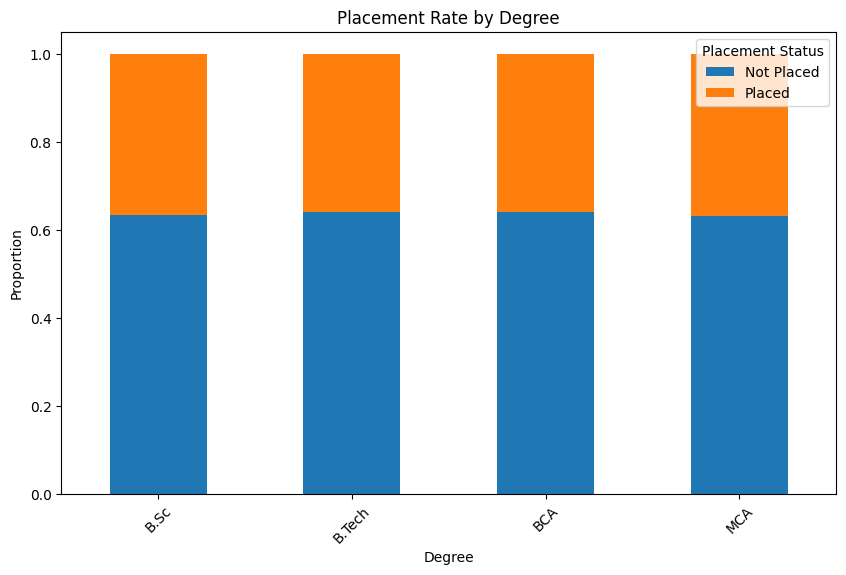

In [12]:
degree_placement = (
    df.groupby(['Degree', 'Placement_Status'])
    .size()
    .unstack()
)

degree_norm = degree_placement.div(degree_placement.sum(axis=1), axis=0)

degree_norm.plot(
    kind='bar',
    stacked=True,
    figsize=(10,6)
)

plt.title('Placement Rate by Degree')
plt.xlabel('Degree')
plt.ylabel('Proportion')
plt.legend(title='Placement Status')
plt.xticks(rotation=45)
plt.show()

Degree is a nominal categorical feature, so instead of raw counts, I focused on normalized placement rates to avoid bias from uneven category sizes. This allowed me to identify which degree types are associated with higher placement likelihood. The normalized bar chart shows that placement proportions across the different degree types are broadly similar, with no major differences between them. While there are slight variations, the overall pattern suggests that degree type is not a visually significant factor in determining whether a student is placed or not.

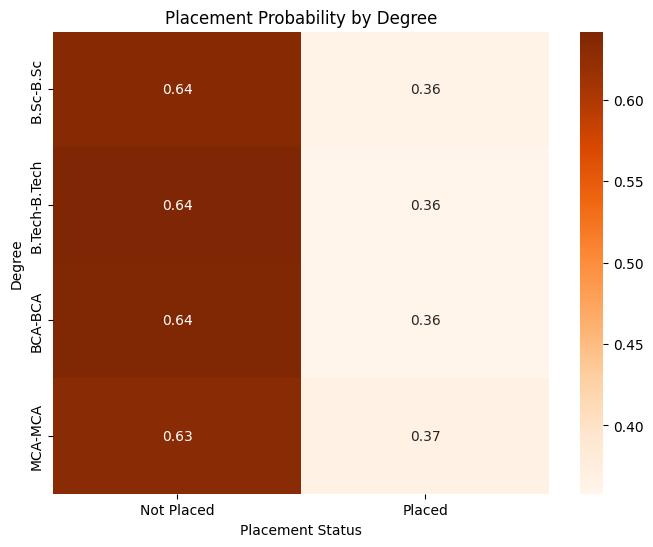

In [13]:
heatmap_data = (
    df.groupby(['Degree', 'Placement_Status'])
    .size()
    .groupby(level=0)
    .apply(lambda x: x / x.sum())
    .unstack()
)

plt.figure(figsize=(8,6))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt='.2f',
    cmap='Oranges'
)

plt.title('Placement Probability by Degree')
plt.xlabel('Placement Status')
plt.ylabel('Degree')
plt.show()


The heatmap displays placement probabilities across degree types, and the values are remarkably consistent. All degrees—B.Sc, B.Tech, BCA, and MCA—show nearly identical probabilities of being placed (around 36–37%) and not placed (around 63–64%). This reinforces the earlier visual findings: degree type does not appear to be a major differentiator in placement outcomes.

#### Soft Skill Feature

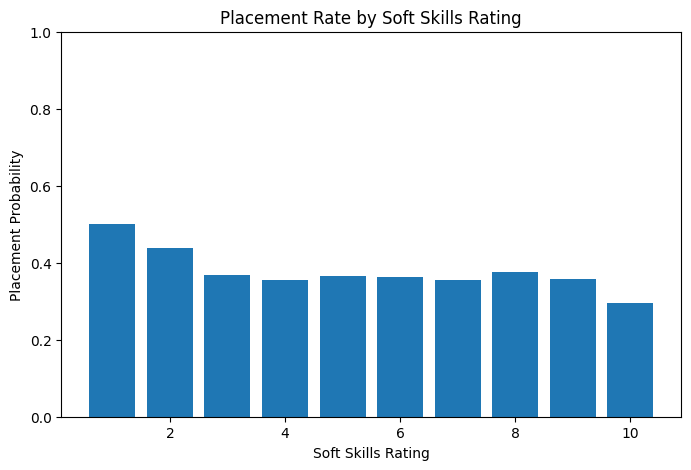

In [42]:
# Ensure ordinal order
soft_order = sorted(df['Soft_Skills_Rating'].unique())

placement_prob = (
    df[df['Placement_Status'] == 'Placed']
    .groupby('Soft_Skills_Rating')
    .size() / df.groupby('Soft_Skills_Rating').size()
)

placement_prob = placement_prob.loc[soft_order]

plt.figure(figsize=(8,5))
plt.bar(placement_prob.index, placement_prob.values)

plt.title('Placement Rate by Soft Skills Rating')
plt.xlabel('Soft Skills Rating')
plt.ylabel('Placement Probability')
plt.ylim(0,1)
plt.show()

The soft skills rating chart reveals a clear and unexpected negative trend: as soft skill ratings increase from 1 to 10, the placement probability steadily declines. Instead of higher ratings corresponding to better outcomes, the highest placement rate appears at rating 1, while the lowest occurs at rating 10. This counterintuitive pattern suggests that soft skills, at least as measured in this dataset, may not function as a meaningful predictor of placement success. It also raises the possibility of subjective or inconsistent scoring, confounding effects from stronger technical or academic attributes, or even reversed interpretation of the rating scale. Overall, the visual indicates that soft skill rating alone does not reliably explain placement outcomes and should be interpreted cautiously within the broader modeling context.

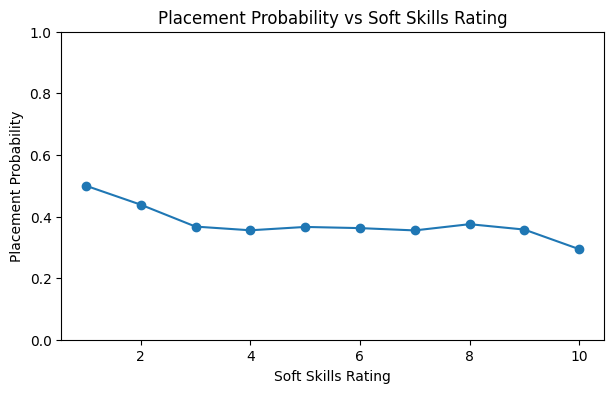

In [33]:
plt.figure(figsize=(7,4))
plt.plot(
    placement_prob.index,
    placement_prob.values,
    marker='o'
)

plt.title('Placement Probability vs Soft Skills Rating')
plt.xlabel('Soft Skills Rating')
plt.ylabel('Placement Probability')
plt.ylim(0,1)
plt.show()

This line graph reinforces the earlier observation of a negative trend between soft skills rating and placement probability. The curve begins with a relatively high placement probability at a soft skills rating of 1 and gradually declines as the rating increases, reaching its lowest point at rating 10. Despite minor fluctuations between ratings 4 and 9, the overall trajectory is downward. This consistent pattern across both bar and line visuals suggests that higher soft skill ratings, contrary to expectations, are associated with lower placement likelihood in this dataset. The result challenges conventional assumptions about the role of soft skills in employability and points to potential issues such as mislabeling, confounding variables, or measurement bias. It underscores the need for cautious interpretation and further investigation before drawing conclusions about the predictive value of this feature.